In [1]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

In [3]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
sls.head()

,id,kdprov,kdkab,kdkec,kddesa,iddesa,idslsnon,nmslsnon,ketua_sls,jenis,...,j_bstt,j_bsbtt,j_bstt_k,j_bskeko,j_segmen,dom,ldom,j_m_all,j_m_30,klas_ur
0,263884,32,1,10,1,3201010001,100,RT 001 RW 001 DUSUN 1,MUHAMAD RAFLI HIDAYAT,1,...,39,1,2,4,1,1,1,51,51,2
1,263885,32,1,10,1,3201010001,200,RT 002 RW 001 DUSUN 1,NURMAN,1,...,60,2,0,7,1,1,1,62,61,2
2,263886,32,1,10,1,3201010001,300,RT 003 RW 001 DUSUN 1,SAENUDIN,1,...,50,2,0,6,1,1,1,58,57,2
3,263887,32,1,10,1,3201010001,400,RT 004 RW 001 DUSUN 1,AEP,1,...,27,1,0,1,1,1,1,31,31,2
4,263888,32,1,10,1,3201010001,500,RT 005 RW 001 DUSUN 1,JEJEN JAELANI,1,...,49,7,3,8,3,1,1,63,57,2


In [6]:
sls.iddesa.unique().shape

(5957,)

In [65]:
ur_path = "C:/Users/jwst2/Python/tesis/jpg/UR/05. Spot SLS ES"
gen_path =  "C:/Users/jwst2/Python/tesis/jpg/general sls spot ES/"
test_path = 'C:/Users/jwst2/Python/tesis/jpg/UR/test sls spot ES/'
model_code_resnet = "R005"
model_code_dense = "D005"

In [7]:
os.chdir(ur_path)
if os.path.isdir('urban') is False:
    os.makedirs('urban')
    os.makedirs('rural')

In [8]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general sls spot ES/"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 1):
                shutil.copy(os.path.join(root, name), ur_path+"/urban/"+name)
            elif(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 2):
                shutil.copy(os.path.join(root, name),ur_path+ "/rural/"+name)
        except Exception:
            print(name)
            pass 

0it [00:00, ?it/s]

32070000002000.jpg
32080000002001.jpg
32080100006001.jpg
32170000006001.jpg


1it [16:43, 1003.76s/it]


In [12]:
split = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/datasplit_ur_desa.csv")

In [13]:
split_test =split

In [15]:
split_test

,Unnamed: 0,iddesa
0,0,3207250012
1,1,3273111002
2,2,3205260016
3,3,3212030010
4,4,3208181004
...,...,...
590,590,3210070009
591,591,3209040007
592,592,3203051007
593,593,3208030017


### Create test

In [16]:
os.chdir(test_path)
if os.path.isdir('urban') is False:
    os.makedirs('urban')
    os.makedirs('rural')

In [17]:
yourpath = ur_path+ "/rural"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                shutil.move(os.path.join(root, name),test_path + "/rural/"+name)
        except Exception:
            print(name)
            pass 

1it [00:38, 38.59s/it]


In [18]:
yourpath =  ur_path+ "/urban"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                shutil.move(os.path.join(root, name), test_path +"/urban/"+name)
        except Exception:
            print(name)
            pass 

1it [02:15, 135.14s/it]


### Run Dataset

In [224]:
path = Path.cwd() / (ur_path)

In [225]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('rural'),Path('urban')]

In [226]:
fname = (path/"rural").ls()[0]
fname

Path('rural/32010100010001.jpg')

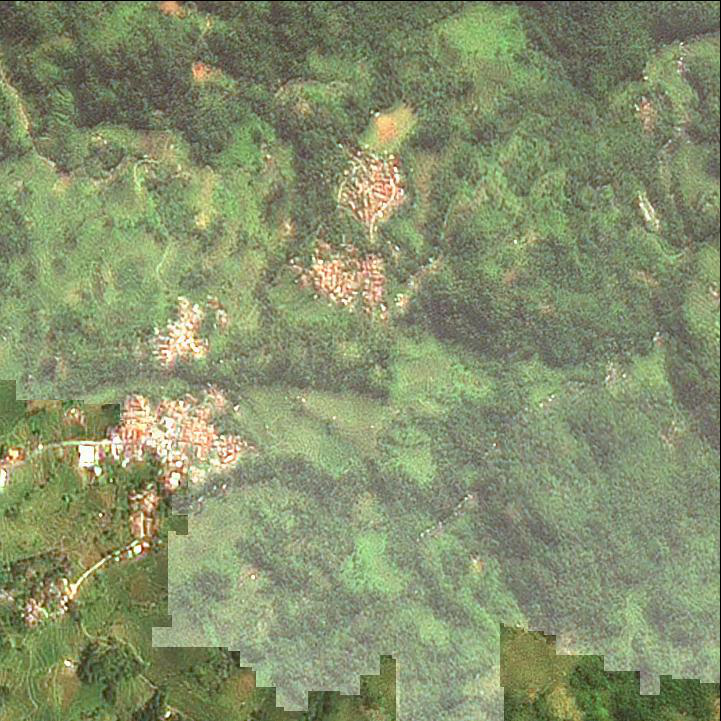

In [227]:
img = Image.open(fname)
img

In [229]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label # extracts the label category from the image's folder name 
                 ,item_tfms = Resize(128)) # data augmentation (mult multiplies the default transformation values)

In [238]:
dls = blocks.dataloaders(path, bs =5)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


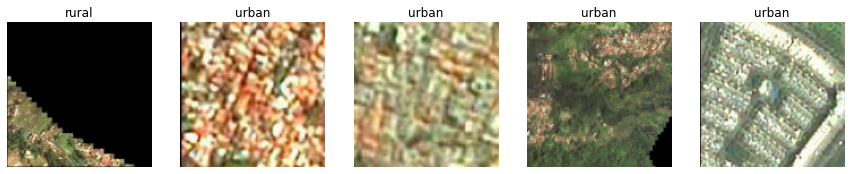

In [239]:
dls.show_batch(nrows=1, ncols=5)

In [240]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

In [241]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.410846,0.381579,0.821398,0.628479,0.761454,0.628479,0.652775,0.846767,1:46:59
1,0.415586,0.379995,0.816597,0.594035,0.785071,0.594035,0.608994,0.850830,1:46:01
2,0.382538,0.366459,0.821600,0.617680,0.775523,0.617680,0.640446,0.859925,1:43:36


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [242]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.fit_one_cycle(5)

In [104]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.324816,0.343184,0.831404,0.710113,0.751467,0.710113,0.726599,0.875955,26:12


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [244]:
dls.vocab

['rural', 'urban']

In [245]:
dls.train.items[175000]

Path('urban/32100900170013.jpg')

In [107]:
learn.export("C:/Users/jwst2/Python/tesis/models/19042022"+ model_code_dense+".pkl")

### Up level

In [246]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [ ]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [110]:
pd.value_counts(true_label)

1    140272
0     37820
dtype: int64

In [111]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.000447,0.999553,32731000020061,1.0,3273100002
1,0.001145,0.998855,32150500070004,1.0,3215050007
2,0.589724,0.410276,32022100131006,0.0,3202210013
3,0.151474,0.848526,32081500110025,1.0,3208150011
4,0.165433,0.834567,32110500010021,1.0,3211050001


In [112]:
pd.value_counts(df.stat)

1.0    147125
0.0     30967
Name: stat, dtype: int64

In [113]:
df["true_lab"] = true_label

In [114]:
pd.value_counts(df.true_lab)

1    140272
0     37820
Name: true_lab, dtype: int64

In [115]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.8521269905442131

In [116]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.000447,0.999553,32731000020061,1.0,3273100002,1
1,0.001145,0.998855,32150500070004,1.0,3215050007,1
2,0.589724,0.410276,32022100131006,0.0,3202210013,1
3,0.151474,0.848526,32081500110025,1.0,3208150011,1
4,0.165433,0.834567,32110500010021,1.0,3211050001,1


In [117]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [118]:
desa_pred.columns = ["pred","true"]

In [119]:
pd.value_counts(df.stat)

1.0    147125
0.0     30967
Name: stat, dtype: int64

In [120]:
for i in np.arange(0.1, 0.95, 0.05):
    value = round(i,2)
    desa_pred["label"+str(value)] = 0
    desa_pred["label"+str(value)][desa_pred.pred > value] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_34804/4109382162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred["label"+str(value)][desa_pred.pred > value] = 1


In [121]:
desa_pred.head()

,pred,true,label0.1,label0.15,label0.2,label0.25,label0.3,label0.35,label0.4,label0.45,label0.5,label0.55,label0.6,label0.65,label0.7,label0.75,label0.8,label0.85,label0.9
iddesa,,,,,,,,,,,,,,,,,,,
3201010001,0.224138,0.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3201010002,0.695652,0.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0
3201010003,0.552632,1.0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
3201010004,0.604167,0.0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0
3201010005,0.433333,1.0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0


In [122]:
for j in range(2,19):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.1
accuracy : 0.768183513614323
precision : 0.7594386242340383
result label0.15
accuracy : 0.7795598657217456
precision : 0.769895498392283
result label0.2
accuracy : 0.7905632226781052
precision : 0.7805027590435316
result label0.25
accuracy : 0.8011935844834017
precision : 0.7906639004149377
result label0.3
accuracy : 0.8069750093248788
precision : 0.7977717048560017
result label0.35
accuracy : 0.8204028347631481
precision : 0.8113612004287245
result label0.4
accuracy : 0.829727713539724
precision : 0.8230920621036518
result label0.45
accuracy : 0.8373741141365162
precision : 0.8330369052912405
result label0.5
accuracy : 0.8498694516971279
precision : 0.8494182067077344
result label0.55
accuracy : 0.8554643789630735
precision : 0.859400418312805
result label0.6
accuracy : 0.8573293547183887
precision : 0.8700214643453374
result label0.65
accuracy : 0.8621782916822082
precision : 0.8852499384388082
result label0.7
accuracy : 0.8593808280492353
precision : 0.89618320610687

In [123]:
pd.value_counts(desa_pred.true)

1.0    3868
0.0    1494
Name: true, dtype: int64

### Test result

In [124]:
path_pred = Path.cwd() / (test_path)
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [125]:
len(test_files)

22054

In [126]:
test_dl = learn.dls.test_dl(test_files)

In [127]:
preds,_ = learn.get_preds(dl  =test_dl)

In [128]:
str(test_files[1])[-18:-4]

'32011500010002'

In [129]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [130]:
test = pd.DataFrame(preds)

In [131]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [132]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [133]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.810315,0.189685,32011500010001,0,3201150001,0.0
1,0.828003,0.171997,32011500010002,0,3201150001,0.0
2,0.811717,0.188283,32011500010003,0,3201150001,0.0
3,0.718211,0.281789,32011500010004,0,3201150001,0.0
4,0.728505,0.271495,32011500010005,0,3201150001,0.0


In [134]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [135]:
desa_pred_test

,stat,true_lab
,mean,mean
iddesa,,
3201010010,0.628571,1.0
3201040001,1.000000,1.0
3201040005,1.000000,1.0
3201050012,1.000000,1.0
3201050013,1.000000,1.0
...,...,...
3278050003,1.000000,1.0
3278071005,0.975000,1.0


In [136]:
desa_pred_test.columns = ["pred","true"]

In [164]:
desa_pred_test["pred_lab"] = 0
desa_pred_test["pred_lab"][desa_pred_test.pred > 0.675] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_34804/1982971506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred_test["pred_lab"][desa_pred_test.pred > 0.675] = 1


In [165]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.8252100840336134
balanced_accuracy_score : 0.7608801717408276
precision : 0.8565121412803532
recall : 0.9086651053864169
f1 : 0.881818181818182
rocauc : 0.7608801717408276


### Resnet

In [166]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

In [167]:
learn_rs.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.392389,0.383353,0.817203,0.623907,0.747309,0.623907,0.646505,0.837134,20:20
1,0.366825,0.358194,0.823874,0.638464,0.762776,0.638464,0.664222,0.862533,22:46
2,0.355325,0.352786,0.825694,0.681682,0.745385,0.681682,0.703257,0.866116,18:52


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [168]:
learn_rs.unfreeze()

In [169]:
learn_rs.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.375521,0.417571,0.816294,0.598266,0.774133,0.598266,0.614854,0.823523,20:38
1,0.379149,0.410677,0.797695,0.528781,0.815501,0.528781,0.499610,0.845004,20:48
2,0.383252,0.373494,0.820488,0.638656,0.749342,0.638656,0.663158,0.851458,24:56
3,0.374101,0.365508,0.818163,0.719743,0.727869,0.719743,0.723618,0.859629,21:37
4,0.346560,0.359920,0.821297,0.613064,0.780911,0.613064,0.634748,0.865127,20:44
5,0.344061,0.350989,0.829535,0.683774,0.754434,0.683774,0.707067,0.868733,20:55
6,0.321731,0.351484,0.826704,0.713546,0.741859,0.713546,0.725622,0.870683,20:28
7,0.300516,0.354546,0.826704,0.678508,0.748940,0.678508,0.701398,0.870332,20:58
8,0.282004,0.371418,0.821752,0.719680,0.733293,0.719680,0.725977,0.865276,22:00
9,0.258623,0.388672,0.821095,0.705473,0.732361,0.705473,0.716933,0.862063,22:01


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (1235

In [170]:
learn_rs.export("C:/Users/jwst2/Python/tesis/models/19042022"+ model_code_resnet+".pkl")

In [171]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [172]:
preds,_ = learn_rs.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [203]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.000015,0.999985,32731000020061,1.0,3273100002,1
1,0.000002,0.999998,32150500070004,1.0,3215050007,1
2,0.350874,0.649126,32022100131006,1.0,3202210013,1
3,0.167167,0.832833,32081500110025,1.0,3208150011,1
4,0.014394,0.985606,32110500010021,1.0,3211050001,1


In [204]:
pd.value_counts(df.stat)

1.0    143403
0.0     34689
Name: stat, dtype: int64

In [205]:
df["true_lab"] = true_label

ValueError: Length of values (22054) does not match length of index (178092)

In [ ]:
pd.value_counts(df.true_lab)

In [ ]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

In [ ]:
df.head()

In [ ]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [ ]:
desa_pred.columns = ["pred","true"]

In [206]:
pd.value_counts(df.stat)

1.0    143403
0.0     34689
Name: stat, dtype: int64

In [207]:
for i in np.arange(0.1, 0.95, 0.025):
    value = round(i,2)
    desa_pred["label"+str(value)] = 0
    desa_pred["label"+str(value)][desa_pred.pred > value] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_34804/935834860.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred["label"+str(value)][desa_pred.pred > value] = 1


In [208]:
desa_pred.head()

,pred,true,label0.1,label0.12,label0.15,label0.18,label0.2,label0.22,label0.25,label0.27,...,label0.7,label0.72,label0.75,label0.77,label0.8,label0.82,label0.85,label0.87,label0.9,label0.92
iddesa,,,,,,,,,,,,,,,,,,,,,
3201010001,0.155172,0.0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3201010002,0.543478,0.0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3201010003,0.710526,1.0,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3201010004,0.479167,0.0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3201010005,0.666667,1.0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [210]:
for j in range(2,36):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.1
accuracy : 0.7720999627004849
precision : 0.761049723756906
result label0.12
accuracy : 0.779373368146214
precision : 0.7669516802545238
result label0.15
accuracy : 0.7954121596419247
precision : 0.7804088241246712
result label0.18
accuracy : 0.8086534875046625
precision : 0.7917864476386037
result label0.2
accuracy : 0.819283849309959
precision : 0.8012887133652047
result label0.22
accuracy : 0.8273032450578143
precision : 0.808515100671141
result label0.25
accuracy : 0.8476314807907497
precision : 0.8282763072950291
result label0.27
accuracy : 0.8554643789630735
precision : 0.8358306188925081
result label0.3
accuracy : 0.8685192092502797
precision : 0.8491940825789357
result label0.32
accuracy : 0.8778440880268557
precision : 0.8596373404969778
result label0.35
accuracy : 0.8881014546810891
precision : 0.8710263396911898
result label0.37
accuracy : 0.8953748601268183
precision : 0.879678530424799
result label0.4
accuracy : 0.9102946661693399
precision : 0.897628551303

### Test result resnet

In [211]:
path_pred = Path.cwd() / (test_path)
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [212]:
test_dl = learn_rs.dls.test_dl(test_files)

In [213]:
preds,_ = learn_rs.get_preds(dl  =test_dl)

In [214]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [215]:
test = pd.DataFrame(preds)

In [216]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [217]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [218]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.834452,0.165548,32011500010001,0,3201150001,0.0
1,0.811685,0.188315,32011500010002,0,3201150001,0.0
2,0.605605,0.394395,32011500010003,0,3201150001,0.0
3,0.361632,0.638368,32011500010004,0,3201150001,1.0
4,0.432751,0.567249,32011500010005,0,3201150001,1.0


In [219]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [220]:
desa_pred_test.columns = ["pred","true"]

In [221]:
desa_pred_test["pred_lab"] = 0
desa_pred_test["pred_lab"][desa_pred_test.pred > 0.625] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_34804/1214450167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred_test["pred_lab"][desa_pred_test.pred > 0.625] = 1


In [222]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.8285714285714286
balanced_accuracy_score : 0.7560011709601874
precision : 0.8509719222462203
recall : 0.9227166276346604
f1 : 0.8853932584269663
rocauc : 0.7560011709601874


In [223]:
accuracy : 0.8117647058823529
balanced_accuracy_score : 0.7623438719750195
precision : 0.8637413394919169
recall : 0.8758782201405152
f1 : 0.8697674418604651
rocauc : 0.7623438719750195